In [415]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [416]:
df = pd.read_csv('data/2014_-_9_Anonymous_Clipper.csv')

In [417]:
#Strip the column names of white space
for col in ['AgencyName', 'PaymentProductName', 'RouteName']:
    df[col] = df[col].str.strip()

In [418]:
#df_clipper_users = pd.read_csv('data/clipper_users.csv')

In [419]:
#df = df.merge(df_clipper_users, on='ClipperCardID')

In [420]:
df_fares = pd.read_csv('data/alt_fares.csv')

In [421]:
df_passes = pd.read_csv('data/passes.csv')

In [480]:
df.shape

(6875630, 20)

In [423]:
df.head()

,Year,Month,CircadianDayOfWeek,CircadianDayOfWeek_Name,RandomWeekID,ClipperCardID,TripSequenceID,AgencyID,AgencyName,PaymentProductID,PaymentProductName,FareAmount,TagOnTime_Time,TagOnLocationID,TagOnLocationName,RouteID,RouteName,TagOffTime_Time,TagOffLocationID,TagOffLocationName
0,2014,9,3,Tuesday,8,0AD15C2C225BBC3121B305970305127B17F8F5DB,2,4,BART,0,Translink E-Cash,5.65,17:20:00.0000000,7,Civic Center (BART),0,NaN,18:20:00.0000000,20.0,Concord (BART)
1,2014,9,3,Tuesday,8,0AD20E3A45A67ED03A40F472244E5A91144E3627,1,4,BART,0,Translink E-Cash,4.20,20:10:00.0000000,31,Coliseum/Oakland Airport,0,NaN,21:00:00.0000000,5.0,24th St Mission
2,2014,9,3,Tuesday,8,0AD3D35CBDC374D820AD99F7F0F87B35D31C95CB,1,4,BART,250,BART HVD 45/48,1.85,17:20:00.0000000,18,Walnut Creek,0,NaN,17:20:00.0000000,19.0,Pleasant Hill
3,2014,9,3,Tuesday,8,0AD3E50ECF4A47C9975593C2D7CAA0750B777E8B,1,18,SF Muni,597,SF Muni Transfer Token,0.00,13:40:00.0000000,0,SFM bus,138,MTANONE,NaN,NaN,NaN
4,2014,9,3,Tuesday,8,0AD3E50ECF4A47C9975593C2D7CAA0750B777E8B,2,18,SF Muni,0,Translink E-Cash,2.25,18:10:00.0000000,0,SFM bus,138,MTANONE,NaN,NaN,NaN


In [424]:
#Baseline scenario: single fares plus monthly passes
df['FareAmount'].sum() #Single fares - approx $10mm

10292760.149999997

In [425]:
df['FareAmount'].sum()*30/21 #Single fares, adjusted to full month - approx $15mm

14703943.071428565

In [426]:
df_baseline = df.groupby(['ClipperCardID', 'PaymentProductName']).count().reset_index()[['ClipperCardID', 'PaymentProductName']]

In [427]:
df_baseline = df_baseline.merge(df_passes, on='PaymentProductName')

In [428]:
df_baseline['PassCost2014'].sum() #Monthly passes - approx $70m

70926256.6

In [429]:
#Scenario 1: assume no monthly passes, everyone pays single fare
df_scenario1 = df.merge(df_fares, on=['AgencyName', 'PaymentProductName'], how='left')

In [430]:
df_scenario1['SingleFareCost'] = df_scenario1['FareCost2014'].combine_first(df_scenario1['FareAmount'])

In [431]:
df_scenario1['SingleFareCost'].sum() #Single fares - approx $16mm

15820397.650000006

In [432]:
df_scenario1['SingleFareCost'].sum()*30/21 #Single fares, adjusted to full month - approx $22mm

22600568.07142858

In [433]:
#Uh-oh, this doesn't make sense. We need to manually adjust the number of trips made with passes.

In [434]:
df_scenario1.groupby('AgencyName').count().reset_index()[['AgencyName', 'Year']].sort_values('Year', ascending=False)

,AgencyName,Year
6,SF Muni,3200258
1,BART,2160862
0,AC Transit,632015
8,VTA,472853
7,SamTrans,153466
2,Caltrain,93331
4,Golden Gate Transit,78894
3,Golden Gate Ferry,66417
9,WETA,17438
5,Napa Solano,96


In [435]:
'''
All 93331 Caltrain trips are E-Cash.
From Caltrain stats:
Clipper Caltrain Monthly Pass 41%
Clipper E-cash 16%
Clipper 8-ride Ticket 4%
Day Pass 10%
Go Pass 18%
One-way ticket 11%
(source: http://www.caltrain.com/Assets/_MarketDevelopment/pdf/Caltrain+Origin+$!26+Destination+Survey+2014.pdf?v=2)

Get expected monthly pass trips: (93331 * 41/16) = 239161
Get expected 8-ride pass trips: (93331 * 4/16) = 23333
Add these into dataset by resampling from data. Assume same station-to-station distribution as E-cash.

PROCESS
1) Existing monthly pass users
 - select monthly pass user
 - generate random number of Caltrain trips for three-week period
 - sample from E-cash data, insert into table

2) Remaining monthly pass users:
 - sample enough users from E-cash data to satisfy remaining users
 - randomize Clipper ID, re-insert into table

3) Other users:
 - as above
 '''

'\nAll 93331 Caltrain trips are E-Cash.\nFrom Caltrain stats:\nClipper Caltrain Monthly Pass 41%\nClipper E-cash 16%\nClipper 8-ride Ticket 4%\nDay Pass 10%\nGo Pass 18%\nOne-way ticket 11%\n(source: http://www.caltrain.com/Assets/_MarketDevelopment/pdf/Caltrain+Origin+$!26+Destination+Survey+2014.pdf?v=2)\n\nGet expected monthly pass trips: (93331 * 41/16) = 239161\nGet expected 8-ride pass trips: (93331 * 4/16) = 23333\nAdd these into dataset by resampling from data. Assume same station-to-station distribution as E-cash.\n\nPROCESS\n1) Existing monthly pass users\n - select monthly pass user\n - generate random number of Caltrain trips for three-week period\n - sample from E-cash data, insert into table\n\n2) Remaining monthly pass users:\n - sample enough users from E-cash data to satisfy remaining users\n - randomize Clipper ID, re-insert into table\n\n3) Other users:\n - as above\n '

In [436]:
#Load Caltrain pass-to-fare lookup
df_caltrain_passes_to_fares = pd.read_csv('data/caltrain_passes_to_fares.csv')

In [437]:
#Select ClipperIDs of existing monthly pass users
df_caltrain_pass_users = df[df['PaymentProductName'].str[:8] == 'Caltrain'][['ClipperCardID',
                                                                             'PaymentProductID',
                                                                             'PaymentProductName',
                                                                             'CircadianDayOfWeek',
                                                                             'RandomWeekID']]

In [438]:
#Merge in fare amounts
df_caltrain_pass_users = df_caltrain_pass_users.merge(df_caltrain_passes_to_fares,
                                                      left_on='PaymentProductName',
                                                      right_on='PaymentProductName')

In [439]:
df_caltrain_pass_users.sort_values('FareAmount', inplace=True)

In [440]:
#Get unique clipper IDs and fare amounts
df_caltrain_pass_users = df_caltrain_pass_users.groupby(['ClipperCardID',
                                                         'FareAmount',
                                                         'PaymentProductID',
                                                         'PaymentProductName',
                                                         'CircadianDayOfWeek',
                                                         'RandomWeekID']).count().reset_index()

In [441]:
df_caltrain_pass_users['index_in_fare_group'] = df_caltrain_pass_users.groupby('FareAmount',
                                                                               'CircadianDayOfWeek',
                                                                               'RandomWeekID').cumcount()

In [442]:
#Change the names of fields we will use to copy over the matched data
df_caltrain_pass_users.rename(mapper=str, columns={'ClipperCardID': 'OriginalClipperCardID',
                                                   'FareAmount': 'OriginalFareAmount',
                                                  'PaymentProductID': 'OriginalPaymentProductID',
                                                  'PaymentProductName': 'OriginalPaymentProductName'}, inplace=True)

In [443]:
#Find users in the E-cash data who match clipper users
df_matched_users = pd.DataFrame(columns=['FareAmount',
                                         'ClipperCardID',
                                         'index_in_fare_group'])

for i, row in df_caltrain_pass_users.groupby('OriginalFareAmount').count().reset_index().iterrows():
    df_temp = df[(df['AgencyName'] == 'Caltrain') & (df['FareAmount'] == row['OriginalFareAmount'])]\
                                  .sample(n=row['OriginalClipperCardID'].astype(int))[['FareAmount', 'ClipperCardID']]\
                                  .reset_index(drop=True)\
                                  .reset_index(drop=False)
    df_temp.rename(mapper=str, columns={'index': 'index_in_fare_group'}, inplace=True)
    df_temp=df_temp[['FareAmount', 'ClipperCardID', 'index_in_fare_group']]
    df_matched_users = pd.concat([df_matched_users, df_temp])

In [444]:
df_matched_users.rename(mapper=str, columns={'ClipperCardID': 'MatchedClipperCardID'}, inplace=True)

In [445]:
df_matched_users['index_in_fare_group'] = df_matched_users['index_in_fare_group'].astype(int)

In [446]:
#Match back to previous clipper ID
df_caltrain_pass_users = df_caltrain_pass_users.merge(df_matched_users,
                                                      left_on=['index_in_fare_group', 'OriginalFareAmount'],
                                                      right_on=['index_in_fare_group', 'FareAmount'])

In [447]:
df_caltrain_pass_users = df_caltrain_pass_users[['OriginalClipperCardID',
                                                 'OriginalPaymentProductID',
                                                 'OriginalPaymentProductName',
                                                 'MatchedClipperCardID']]

In [448]:
#Get Caltrain trips for these Clipper IDs
df2 = df_caltrain_pass_users.merge( df[df['AgencyName'] == 'Caltrain'], left_on='MatchedClipperCardID', right_on='ClipperCardID')

In [449]:
#Set matched fields to originals
df2['ClipperCardID'] = df2['OriginalClipperCardID']
df2['PaymentProductID'] = df2['OriginalPaymentProductID']
df2['PaymentProductName'] = df2['OriginalPaymentProductName']
df2['FareAmount'] = 0.0

In [450]:
#Finally, drop added columns
df2.drop(columns=['OriginalClipperCardID','OriginalPaymentProductID','OriginalPaymentProductName', 'MatchedClipperCardID'], inplace=True)

In [451]:
#Save point!
df2.to_csv('data/df2.csv', index=False)

In [37]:
93331/(1597986*21/30)

0.08343627541167445

In [159]:
239161*200

47832200

In [43]:
random.uniform(0, 1)

0.7378189661003536

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c80c630>]],
      dtype=object)

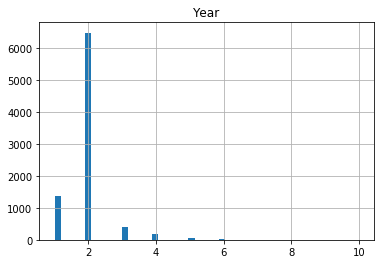

In [194]:
df[df['PaymentProductName']=='AC Transit Adult TransBay (31 Day Rolling) pass'].groupby('ClipperCardID').count()[['Year']].hist(bins=50)

In [162]:
np.sort(df[df['AgencyName']=='Caltrain']['FareAmount'].unique())

array([ 0.  ,  1.25,  2.25,  2.75,  3.25,  4.25,  4.75,  5.25,  6.25,
        6.75,  8.75, 10.75, 12.75])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13e13f588>]],
      dtype=object)

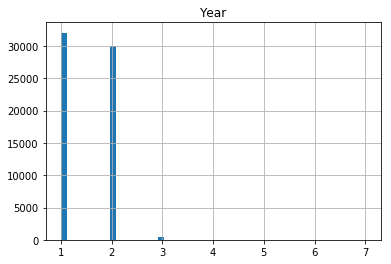

In [196]:
df[df['AgencyName']=='Caltrain'].groupby('ClipperCardID').count()[['Year']].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13c287a20>]],
      dtype=object)

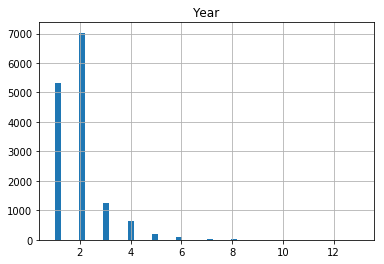

In [173]:
df[df['PaymentProductName'].str[:8] == 'Caltrain'].groupby('ClipperCardID').count()[['Year']].hist(bins=50)

In [52]:
#Get UserIDs of people with Caltrain passes
np.unique(df[df['PaymentProductName'].str[:8] == 'Caltrain'][['UserID']]).shape

(5916,)

In [ ]:
'''
THIS IS SUSPECT METHODOLOGY - revisit later

Assume BART is capturing all trips.
BART annual ridership in 2014 was 126,603,000.
Assume (126,603,000 * 3/52) = 7304019 for those three weeks.
This means BART ridership using Clipper is (2160862/7304019) = 29.5%.

Caltrain annual ridership in 2014 was 15,596,000 .
Assume (15596000 * 3/52) = 899769 for those three weeks.
Adjusted for Clipper coverage, we should see (899769 * 0.295) = 265432 Clipper riders
This means we are missing (265432 - 93331) = 172101 pass riders
This gives us a pass usage ratio of (172101/(172101+93331)) = 64.8%, which sounds about right

Repeat for all agencies.
Ridership data comes from SPUR Seamless Transit, with Golden Gate Ferry from: http://goldengateferry.org/researchlibrary/statistics.php#annual
'''

In [27]:
df_scenario1['PassFlag'] = df_scenario1['FareCost2014'].notnull()

In [28]:
df_pass_usage = df_scenario1.groupby(['AgencyName', 'PassFlag']).count().reset_index()[['AgencyName', 'PassFlag', 'Year']].sort_values('Year', ascending=False)
df_pass_usage

,AgencyName,PassFlag,Year
9,SF Muni,True,2023783
2,BART,False,1937402
8,SF Muni,False,1176475
13,VTA,True,422943
1,AC Transit,True,388830
0,AC Transit,False,243185
3,BART,True,223460
11,SamTrans,True,111057
4,Caltrain,False,93331
6,Golden Gate Transit,False,78894


In [29]:
df_pass_usage = df_pass_usage.pivot(index='AgencyName', columns='PassFlag', values='Year').reset_index()
df_pass_usage.fillna(0, inplace=True)
df_pass_usage.rename(index=str, columns={False: "SingleFares", True: "PassFares"}, inplace=True)
df_pass_usage['SingleFares'] = df_pass_usage['SingleFares'].astype('int')
df_pass_usage['PassFares'] = df_pass_usage['PassFares'].astype('int')
df_pass_usage

PassFlag,AgencyName,SingleFares,PassFares
0,AC Transit,243185,388830
1,BART,1937402,223460
2,Caltrain,93331,0
3,Golden Gate Ferry,66417,0
4,Golden Gate Transit,78894,0
5,Napa Solano,96,0
6,SF Muni,1176475,2023783
7,SamTrans,42409,111057
8,VTA,49910,422943
9,WETA,17438,0


In [30]:
df_ridership = pd.read_csv('data/annual_ridership.csv')

In [31]:
df_pass_usage = df_pass_usage.merge(df_ridership, on='AgencyName')
df_pass_usage

,AgencyName,SingleFares,PassFares,2014Ridership
0,AC Transit,243185,388830,55235000
1,BART,1937402,223460,126603000
2,Caltrain,93331,0,15596000
3,Golden Gate Ferry,66417,0,2540691
4,Golden Gate Transit,78894,0,6662309
5,Napa Solano,96,0,550000
6,SF Muni,1176475,2023783,223701000
7,SamTrans,42409,111057,12446000
8,VTA,49910,422943,44244000
9,WETA,17438,0,607000


In [32]:
df_pass_usage['PeriodRidership'] = (df_pass_usage['2014Ridership'] * 3/52).astype('int')
df_pass_usage

,AgencyName,SingleFares,PassFares,2014Ridership,PeriodRidership
0,AC Transit,243185,388830,55235000,3186634
1,BART,1937402,223460,126603000,7304019
2,Caltrain,93331,0,15596000,899769
3,Golden Gate Ferry,66417,0,2540691,146578
4,Golden Gate Transit,78894,0,6662309,384363
5,Napa Solano,96,0,550000,31730
6,SF Muni,1176475,2023783,223701000,12905826
7,SamTrans,42409,111057,12446000,718038
8,VTA,49910,422943,44244000,2552538
9,WETA,17438,0,607000,35019


In [40]:
df_pass_usage['RidershipDataCoverage'] = (df_pass_usage['SingleFares'] + df_pass_usage['PassFares']) / df_pass_usage['PeriodRidership']

In [41]:
df_pass_usage

,AgencyName,SingleFares,PassFares,2014Ridership,PeriodRidership,PeriodClipperRidership,RidershipDataCoverage
0,AC Transit,243185,388830,55235000,3186634,942751,0.198333
1,BART,1937402,223460,126603000,7304019,2160862,0.295846
2,Caltrain,93331,0,15596000,899769,266192,0.103728
3,Golden Gate Ferry,66417,0,2540691,146578,43364,0.453117
4,Golden Gate Transit,78894,0,6662309,384363,113712,0.205259
5,Napa Solano,96,0,550000,31730,9387,0.003026
6,SF Muni,1176475,2023783,223701000,12905826,3818132,0.247970
7,SamTrans,42409,111057,12446000,718038,212428,0.213730
8,VTA,49910,422943,44244000,2552538,755157,0.185248
9,WETA,17438,0,607000,35019,10360,0.497958


In [33]:
df_bart = df_pass_usage[df_pass_usage['AgencyName']=='BART']
clipper_adoption_rate = float((df_bart['SingleFares'] + df_bart['PassFares'])/df_bart['PeriodRidership'])
clipper_adoption_rate

0.29584561595472303

In [34]:
df_pass_usage['PeriodClipperRidership'] = (df_pass_usage['PeriodRidership'] * clipper_adoption_rate).astype('int')
df_pass_usage

,AgencyName,SingleFares,PassFares,2014Ridership,PeriodRidership,PeriodClipperRidership
0,AC Transit,243185,388830,55235000,3186634,942751
1,BART,1937402,223460,126603000,7304019,2160862
2,Caltrain,93331,0,15596000,899769,266192
3,Golden Gate Ferry,66417,0,2540691,146578,43364
4,Golden Gate Transit,78894,0,6662309,384363,113712
5,Napa Solano,96,0,550000,31730,9387
6,SF Muni,1176475,2023783,223701000,12905826,3818132
7,SamTrans,42409,111057,12446000,718038,212428
8,VTA,49910,422943,44244000,2552538,755157
9,WETA,17438,0,607000,35019,10360


In [35]:
df_pass_usage['PeriodClipperRidership'] - df_pass_usage['SingleFares'] - df_pass_usage['PassFares']

0    310736
1         0
2    172861
3    -23053
4     34818
5      9291
6    617874
7     58962
8    282304
9     -7078
dtype: int64